In [1]:
import sys
import os
from re import split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
# from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from dask.distributed import Client, progress
from dask.distributed import Client, LocalCluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots
# import tensorflow_docs.modeling
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
from scipy.special import gamma
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
# from sklearn.metrics import confusion_matrix
import xarray as xr
from matplotlib.colors import ListedColormap
sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

In [2]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  # raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
else:
  print(device_name)


Found GPU at: 


2023-08-08 11:53:33.042226: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 11:53:33.046581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-08 11:53:33.046624: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-08 11:53:33.046659: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keeling-j01): /proc/driver/nvidia/version does not exist


In [3]:
cluster = LocalCluster()  
cluster

LocalCluster(a9cbfef0, 'tcp://127.0.0.1:43360', workers=8, threads=48, memory=48.00 GiB)

In [4]:
def norm_gamma(d, nw, mu, dm):
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

def plot_history(history):
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    hist['epoch'] = history.epoch


    ax.set_xlabel('Epoch')
    ax.set_ylabel('Mean Abs Error')
    ax.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    try:
        ax.plot(hist['epoch'], hist['val_mae'],
                 label = 'Val Error')
    except KeyError:
        pass
    # plt.ylim([0,5])
    ax.legend()

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Mean Square Error')
    ax1.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    try:
        ax1.plot(hist['epoch'], hist['val_mse'],
                  label = 'Val Error')
    except KeyError:
        pass
    # plt.ylim([0,3])
    ax1.legend()
    plt.show()
    
def metrics_pd(x, xpred):
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

In [5]:
store = f"{path_data}/cloud_probes/zarr/dm_retrieved_Lear_corr_merged.zarr"
store1 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
store11 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
store2 = f"{path_data}/cloud_probes/zarr/combined_psd_P3B_600_1000_5_bins.zarr"
store3 = f"{path_data}/cloud_probes/zarr/dm_retrieved_P3B_corr_merged.zarr"
store

'/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/zarr/dm_retrieved_Lear_corr_merged.zarr'

In [221]:
dm_lear = xr.open_zarr(store)
dm_p3b = xr.open_zarr(store3)
ds_lear = xr.open_zarr(store1)
ds_lear['altitude'] = ds_lear['altitude'] * 0.3046
ds_lear = ds_lear.drop_sel(time='2019-09-09 00:54:08')
ds_p3b = xr.open_zarr(store2)

In [284]:
ds_new_lear = xr.merge([dm_lear, ds_lear], compat='override')
ds_new_p3b = xr.merge([dm_p3b, ds_p3b], compat='override')

In [285]:
new_cols = ['dbz_t_ka', 'dbz_t_ku', 'Att_ku', "Att_ka", 'nt', 'lwc_cum', 'mu', 'new_mu', 'mu3', 'mu_bf','sigma', 'sigmap', 'dm', 
            'log10_nw', 'r', 'dfr', 'temp', 'vert_vel', 'altitude','z_ku_mu1', 'z_ku_mu2', 'z_ku_mu3', 'z_ku_mu_bf',
            'z_ka_mu1', 'z_ka_mu2', 'z_ka_mu3', 'z_ka_mu_bf', 'lon', 'lat', 'r', 'r_dm_gm_mu_3', 'r_gpm_operational', 'r_true_nw_mu_dm']

In [286]:
dm_l = ds_new_lear[new_cols]
dm_p = ds_new_p3b[new_cols]
ds = xr.concat([dm_l, dm_p], dim='time')
ds = ds.where(ds.lwc_cum > 0.01, drop=True)

In [287]:
df = ds.to_dataframe()
df = df.reset_index()
df.shape

(8710, 33)

In [282]:
df['logr'] = np.log10(df.r)
df['lognt'] = np.log10(df.nt)
df['loglwc'] = np.log10(df.lwc_cum)

cols = ['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]
scaler = StandardScaler()
df[cols]= scaler.fit_transform(df[['sigma', 'dm', 'log10_nw', 'logr', 'lognt', 'loglwc']])

n_c = 6
X = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]
kmeans = KMeans(n_clusters=n_c, random_state=10)
kmeans.fit(X)

df['kmeans_6'] = kmeans.labels_

/data/keeling/a/alfonso8/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [283]:
df['dfr'] = df['dbz_t_ku'] - df['dbz_t_ka']
df['dm_class'] = (df.dm > 1.0).astype(int)
df.shape

(505180, 46)

In [151]:
sns.set(rc={"figure.dpi":120, 'savefig.dpi':120})

In [152]:
# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
my_cmap6 = ListedColormap(sns.color_palette(flatui).as_hex())

colors6 = my_cmap6(np.linspace(0,1,n_c))

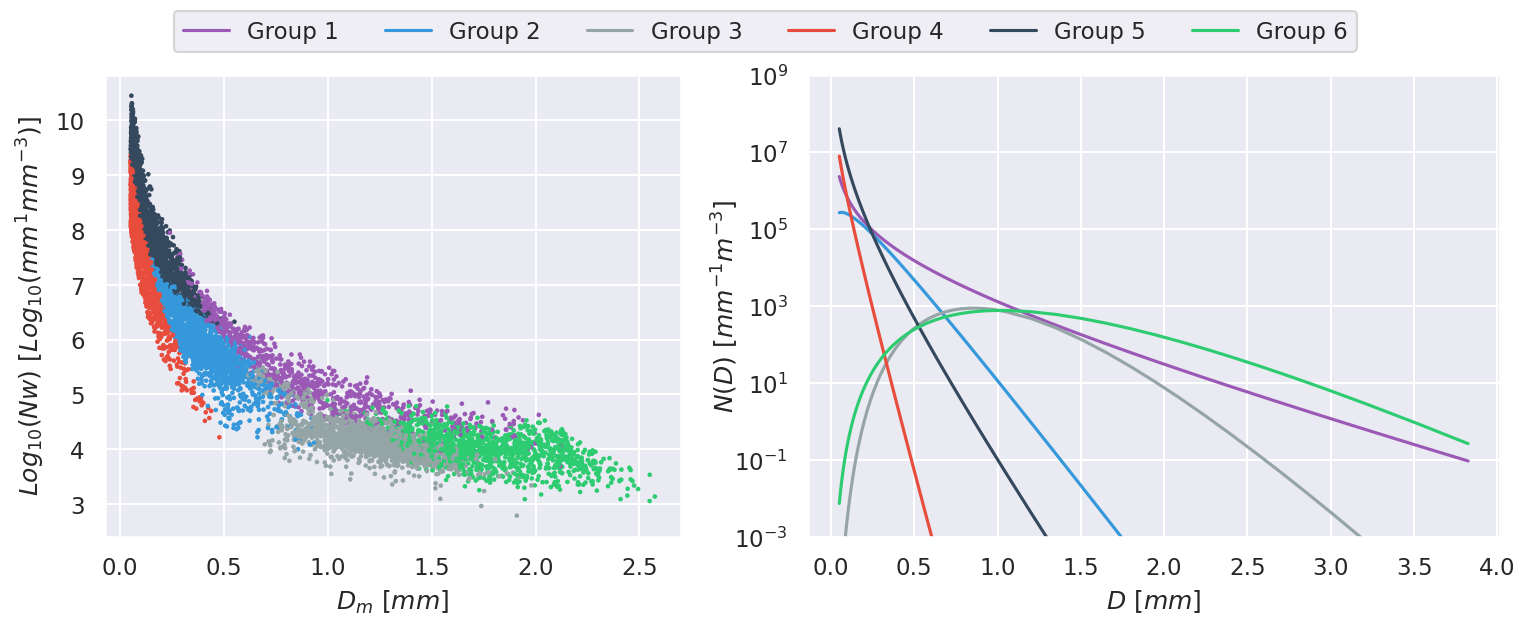

In [153]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['kmeans_6'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
# fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e9)
d = ds_lear.diameter/1000
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].quantile(.50)
    dm = df_sub['dm'].quantile(.50)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(ds_lear.diameter/1000, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

# Train neural Network

In [17]:
X, Y = df[['dbz_t_ku', 'dfr']], df[['log10_nw', 'dm', 'new_mu']]

In [18]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
Y_scaled = scaler_y.fit_transform(Y)

In [19]:
Y_scaled = np.append(Y_scaled, df.dm_class.values[:, np.newaxis], axis=1)
Y_scaled = np.append(Y_scaled, df.kmeans_6.values[:, np.newaxis], axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.33, random_state=42, stratify=df.kmeans_6)

In [21]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

In [22]:
model = build_model()

In [23]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


history = model.fit(X_train, y_train[:, :3],
                    validation_data=(X_test, y_test[:,:3]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])

2023-08-08 11:53:39.458319: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



....................................................................................................
...........................................

In [24]:
hist = pd.DataFrame(history.history)

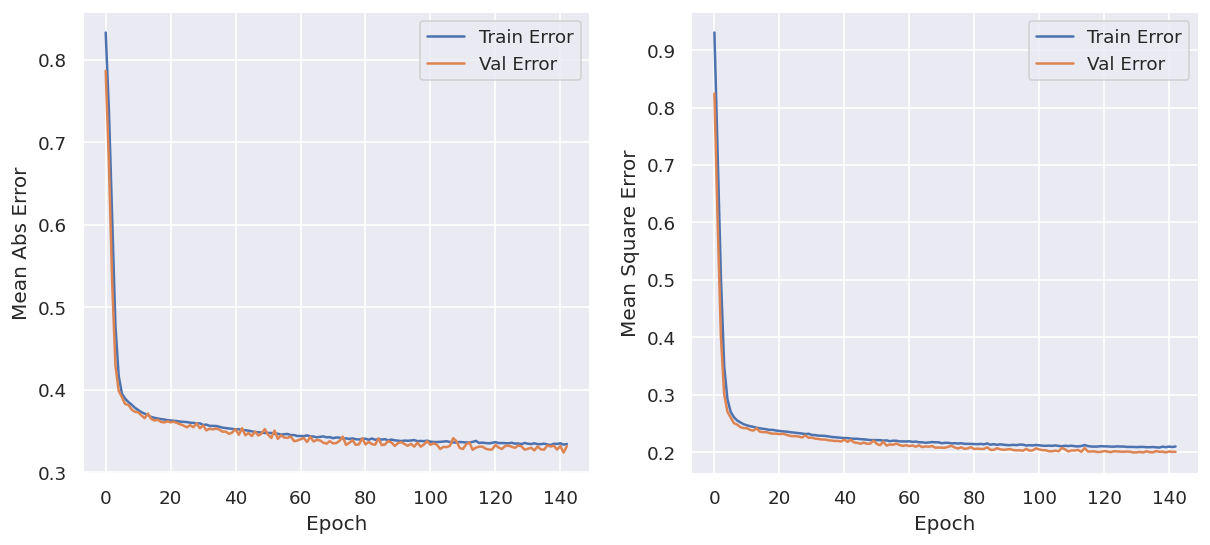

In [25]:
plot_history(history)

In [26]:
yhat = model.predict(X_test)
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(y_test[:, :3])

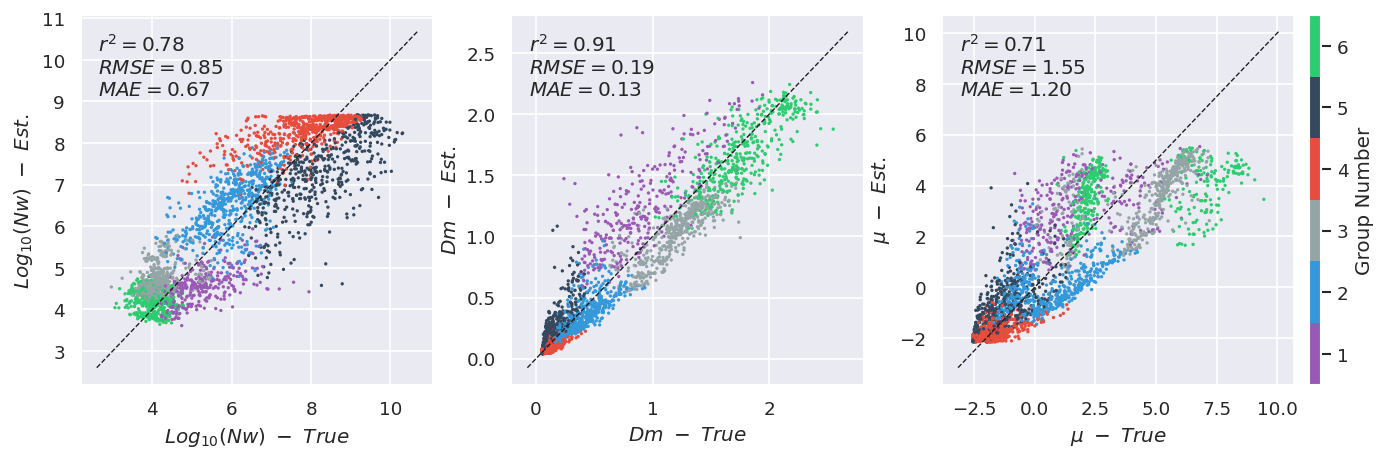

In [27]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

In [28]:
del scaler_x, scaler_y

# NN using balanced data

In [29]:
lower, greater = np.bincount(df['dm_class'])
total = greater + lower
print('Examples:\n    Total: {}\n    greater: {} ({:.2f}% of total)\n'.format(
    total, greater, 100 * greater / total))

Examples:
    Total: 8710
    greater: 2807 (32.23% of total)



In [30]:
X, Y = df[['dbz_t_ku', 'dfr', 'log10_nw', 'dm', 'new_mu']].values, df[['dm_class', 'kmeans_6']].values

In [31]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[:, 2:])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.33, random_state=42, stratify=df.kmeans_6)

In [33]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0].squeeze())
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:,0].squeeze())}")

Training target statistics: Counter({0: 3942, 1: 3942})
Testing target statistics: Counter({0: 1961, 1: 914})


In [34]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

In [35]:
model = build_model()

In [36]:
EPOCHS = 500
history = model.fit(X_res[:, :2], X_res[:, 2:],
                    validation_data=(X_res[:, :2], X_res[:, 2:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


............................................................................................

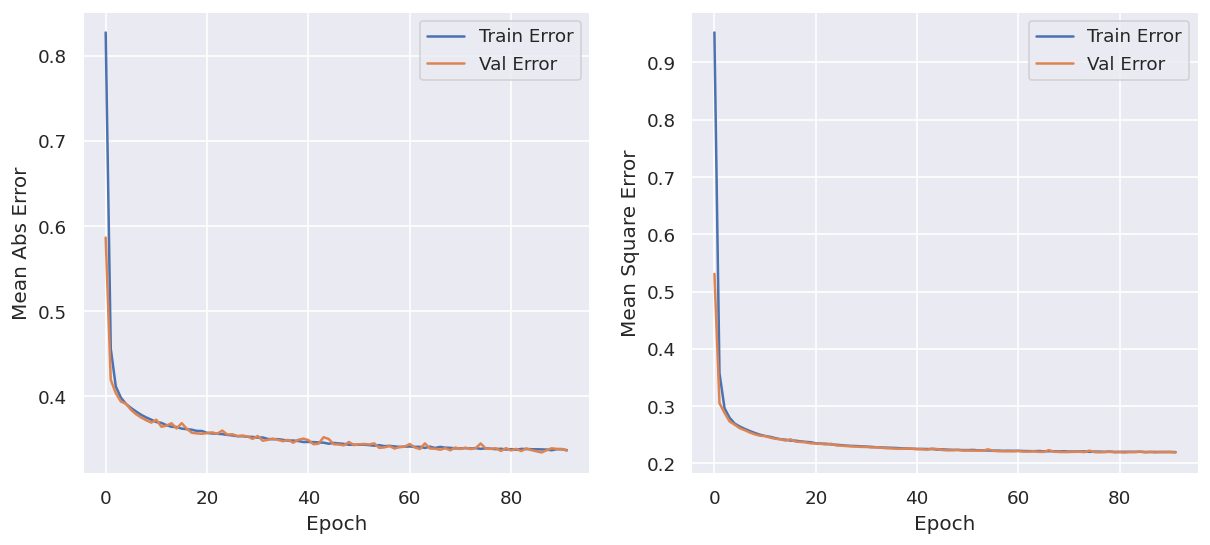

In [37]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [38]:
yhat = model.predict(X_test[:, :2])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 2:])

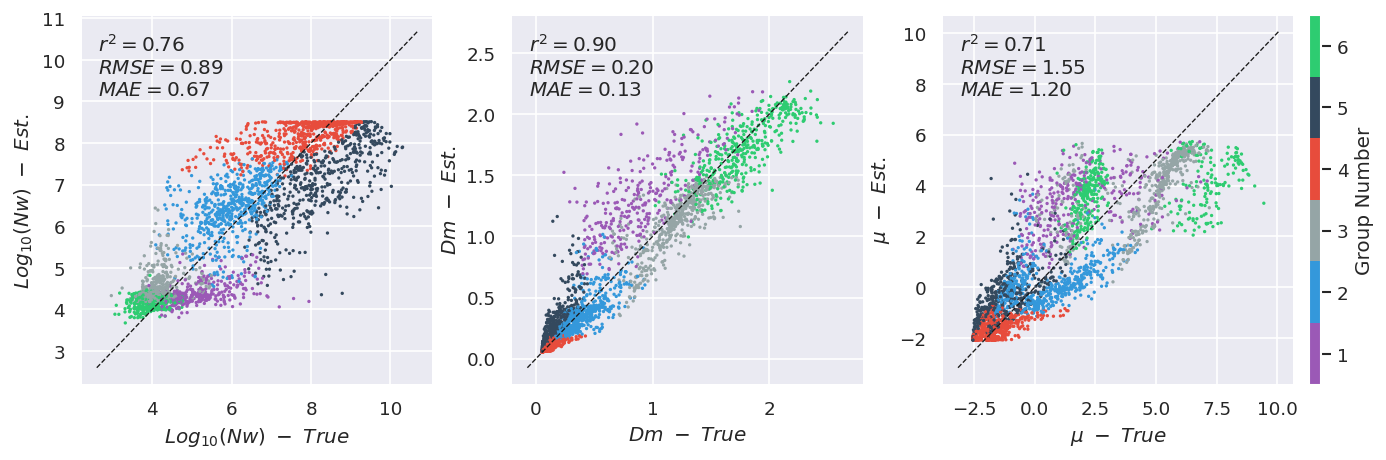

In [39]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

# Adding more parameters to the NN (Temp)

In [40]:
X, Y = df[['dbz_t_ku', 'dfr', 'temp', 'log10_nw', 'dm', 'new_mu']], df[['dm_class', 'kmeans_6']]

In [41]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.33, random_state=42, stratify=df.kmeans_6)

In [43]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0])
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0: 3942, 1: 3942})
Testing target statistics: Counter({0: 1961, 1: 914})


In [44]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [45]:
model = build_model()

In [46]:
class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
EPOCHS = 500
history = model.fit(X_res[:, :3], X_res[:, 3:],
                    validation_data=(X_test[:, :3], X_test[:, 3:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
....................................................................................................
.................................................

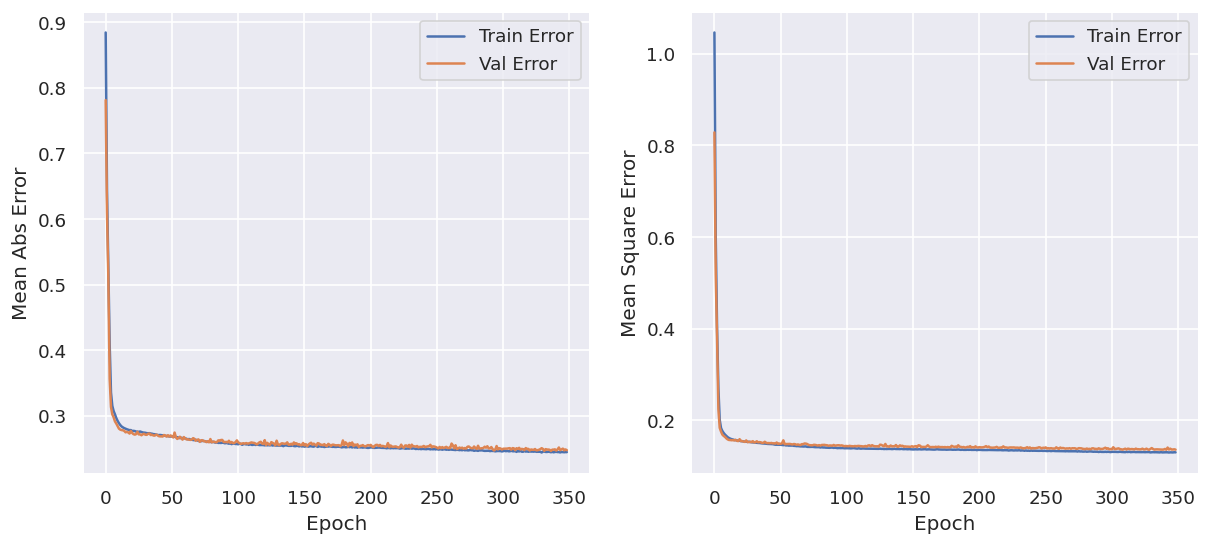

In [47]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [48]:
yhat = model.predict(X_test[:, :3])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 3:])

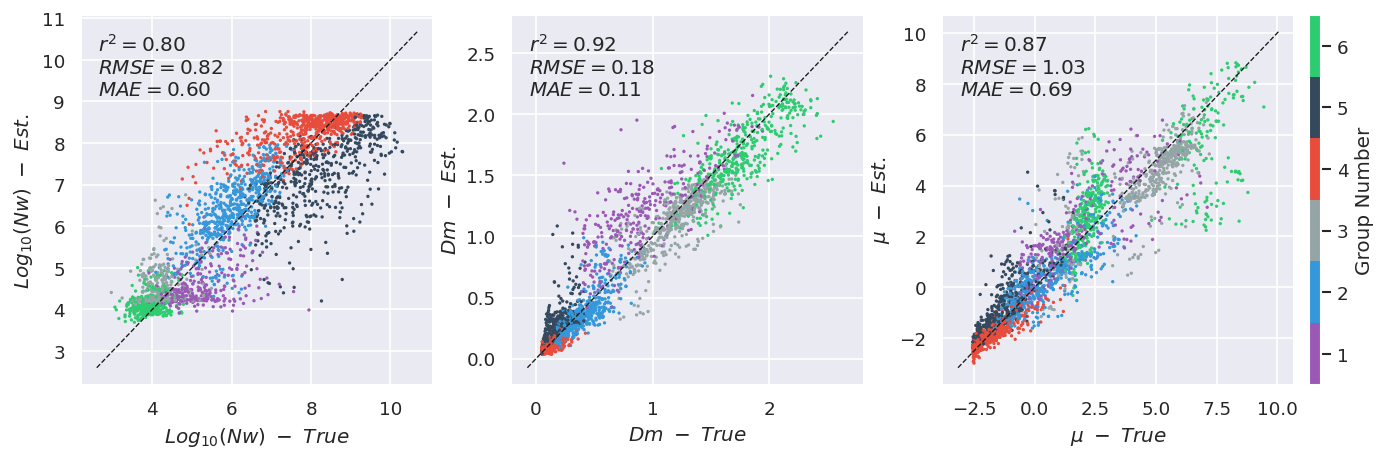

In [49]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

In [50]:
del scaler_x, scaler_y

# Adding now Height above cloud base

In [51]:
_df = pd.read_parquet(f"{path_data}/cloud_probes/parquet/all_data_cb.parquet").reset_index()
df = df.reset_index()

df['hacb'] = _df['hacb']
X, Y = df[['dbz_t_ku', 'dfr', 'temp', 'hacb', 'log10_nw', 'dm', 'new_mu']], df[['dm_class', 'kmeans_6']]
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.33, random_state=42, stratify=df.kmeans_6)

In [52]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:,0])
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:,0])}")

Training target statistics: Counter({0: 3942, 1: 3942})
Testing target statistics: Counter({0: 1961, 1: 914})


In [53]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [54]:
EPOCHS = 500
history = model.fit(X_res[:, :4], X_res[:, 4:],
                    validation_data=(X_test[:, :4], X_test[:, 4:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
.............................................

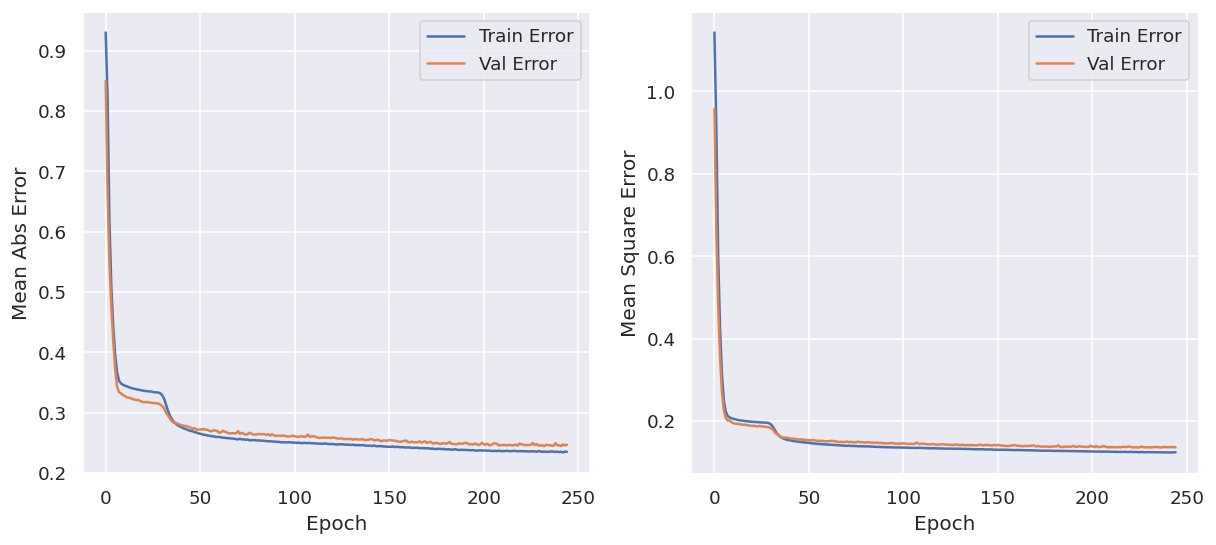

In [55]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [56]:
yhat = model.predict(X_test[:, :4])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

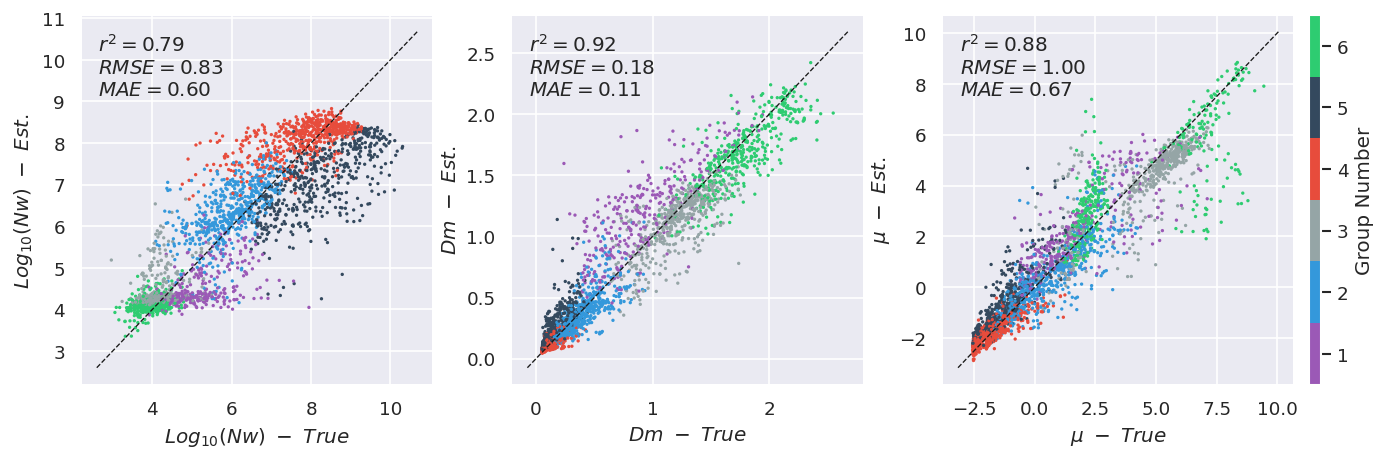

In [57]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

In [58]:
del scaler_x, scaler_y

# Testing with height

In [59]:
X, Y = df[['dbz_t_ku', 'dfr', 'temp', 'altitude', 'log10_nw', 'dm', 'new_mu']], df[['dm_class', 'kmeans_6']]

scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.33, random_state=42, stratify=df.kmeans_6)

over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0])
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0: 3942, 1: 3942})
Testing target statistics: Counter({0: 1961, 1: 914})


In [60]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

In [61]:
model = build_model()

In [62]:
EPOCHS = 500
history = model.fit(X_res[:, :4], X_res[:, 4:],
                    validation_data=(X_test[:, :4], X_test[:, 4:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
.................................................................

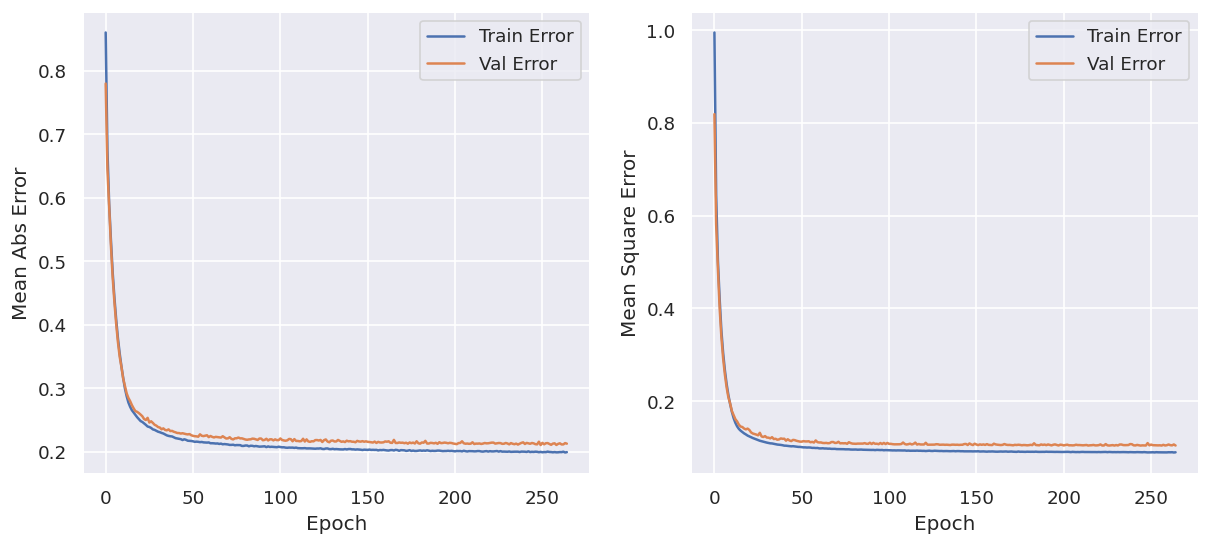

In [63]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [64]:
yhat = model.predict(X_test[:, :4])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

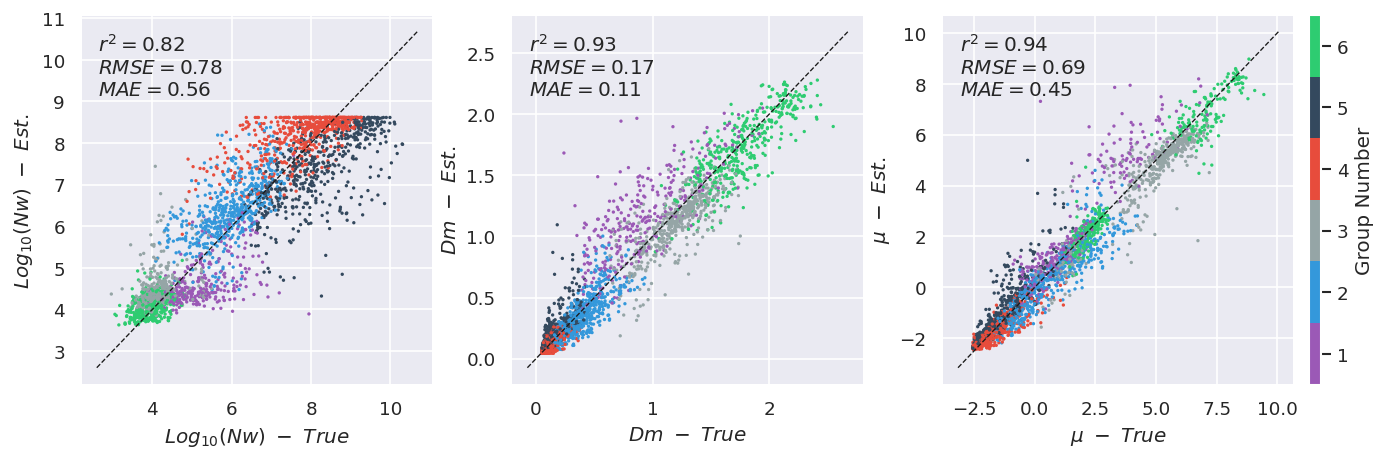

In [65]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

# Adding LWC

In [66]:
X, Y = df[['dbz_t_ku', 'dfr', 'temp', 'lwc_cum', 'altitude', 'log10_nw', 'dm', 'new_mu']], df[['dm_class', 'kmeans_6']]

In [67]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.33, random_state=42, stratify=df.kmeans_6)
X_train.shape

(5835, 8)

In [69]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0])
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0: 3942, 1: 3942})
Testing target statistics: Counter({0: 1961, 1: 914})


In [70]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [71]:
EPOCHS = 500
history = model.fit(X_res[:, :5], X_res[:, 5:],
                    validation_data=(X_test[:, :5], X_test[:, 5:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

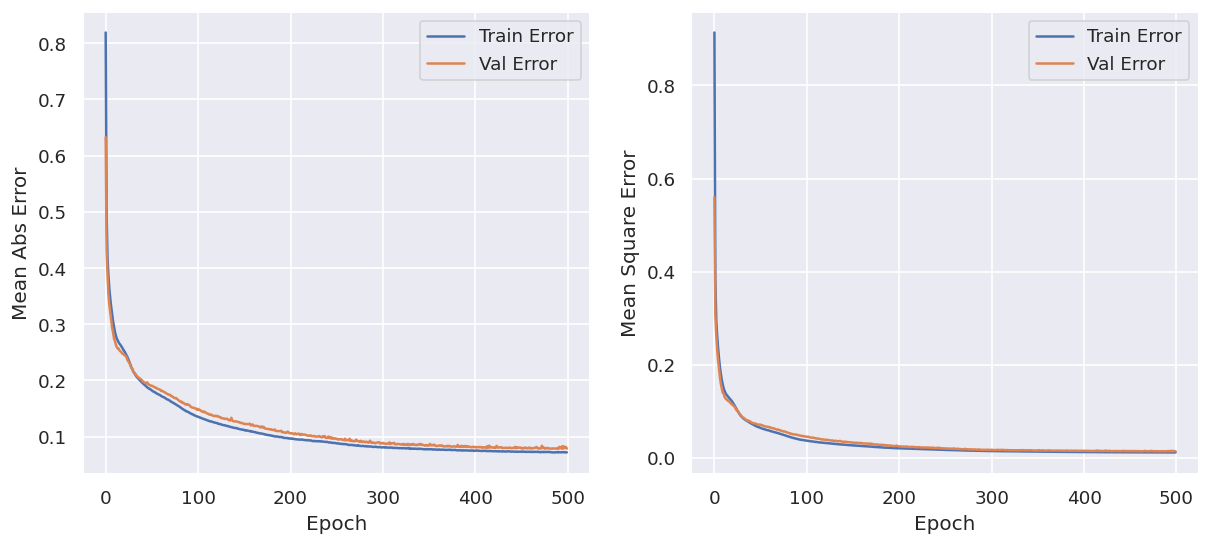

In [72]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [73]:
yhat = model.predict(X_test[:, :5])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 5:])

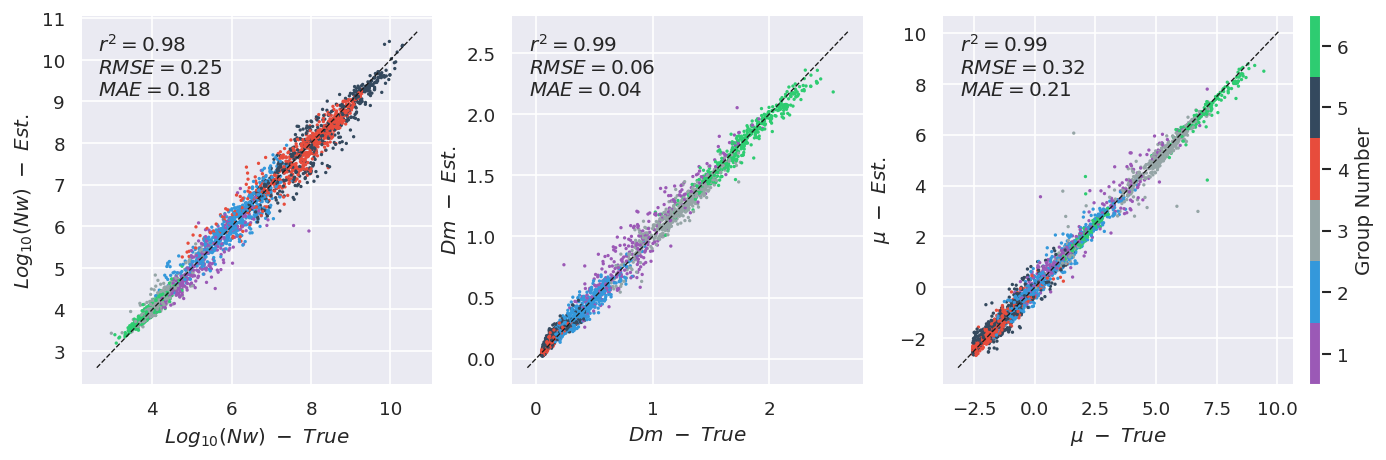

In [74]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

In [75]:
del scaler_x, scaler_y

# Adding attenuation (Ku) instead of lwc

In [76]:
X, Y = df[['dbz_t_ku', 'dfr', 'temp', 'Att_ku', 'altitude', 'log10_nw', 'dm', 'new_mu']], df[['dm_class', 'kmeans_6']]

In [77]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.33, random_state=42, stratify=df.kmeans_6)
X_train.shape

(5835, 8)

In [79]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0])
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0: 3942, 1: 3942})
Testing target statistics: Counter({0: 1961, 1: 914})


In [80]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [81]:
EPOCHS = 500
history = model.fit(X_res[:, :5], X_res[:, 5:],
                    validation_data=(X_test[:, :5], X_test[:, 5:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................................................

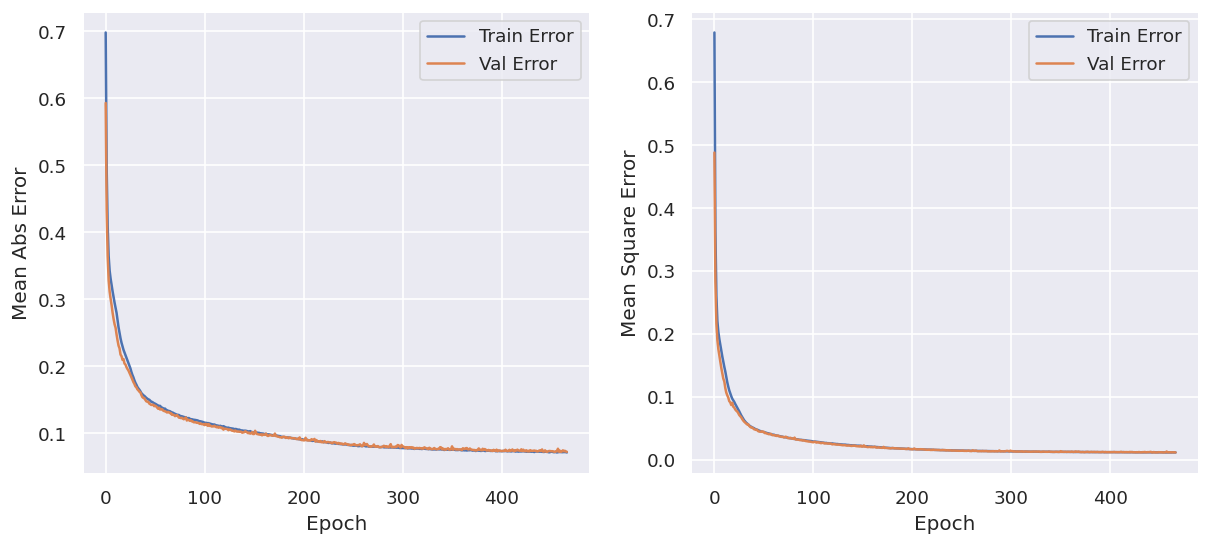

In [82]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [83]:
yhat = model.predict(X_test[:, :5])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 5:])

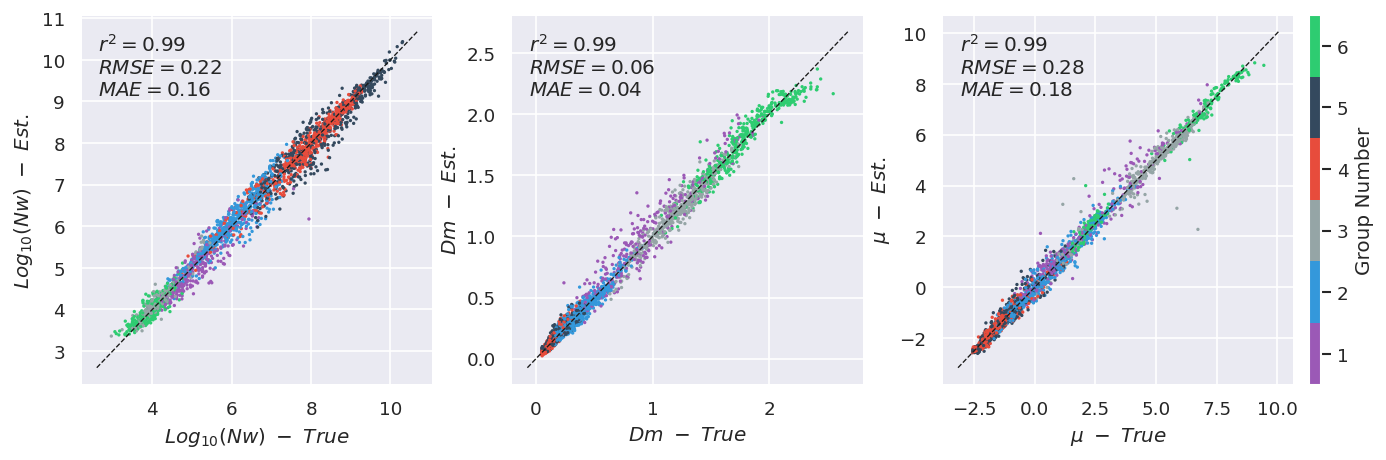

In [84]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

# Now using Attenuation at Ka

In [85]:
X, Y = df[['dbz_t_ku', 'dfr', 'temp', 'Att_ka', 'altitude', 'log10_nw', 'dm', 'new_mu']], df[['dm_class', 'kmeans_6']]

In [86]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.33, random_state=42, stratify=df.kmeans_6)
X_train.shape

(5835, 8)

In [88]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0])
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0: 3942, 1: 3942})
Testing target statistics: Counter({0: 1961, 1: 914})


In [89]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [90]:
EPOCHS = 500
history = model.fit(X_res[:, :5], X_res[:, 5:],
                    validation_data=(X_test[:, :5], X_test[:, 5:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
....................................................................................................
..................................

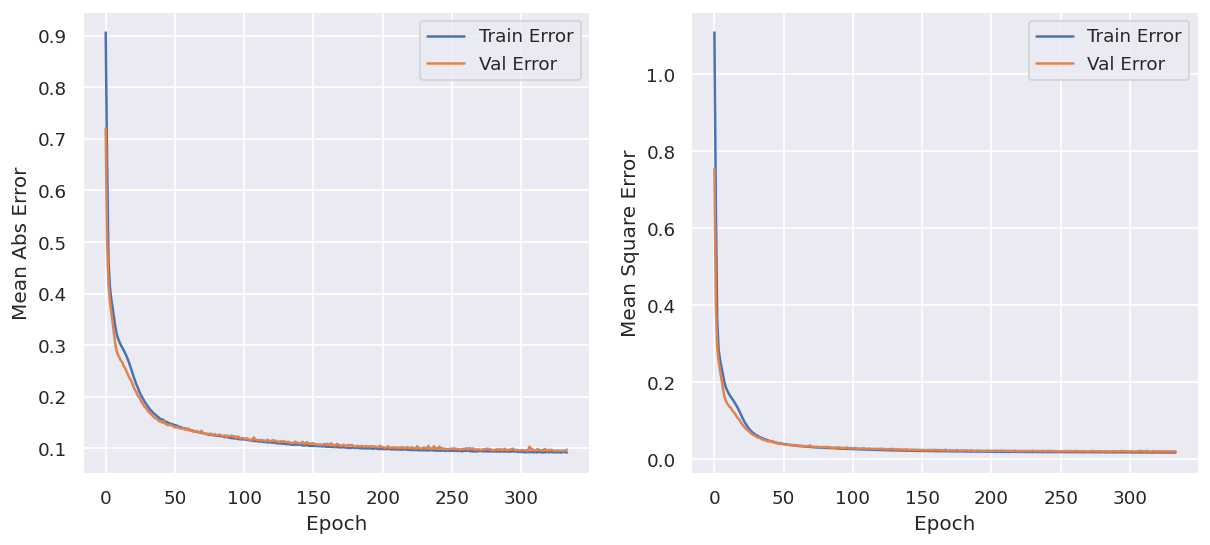

In [91]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [92]:
yhat = model.predict(X_test[:, :5])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 5:])

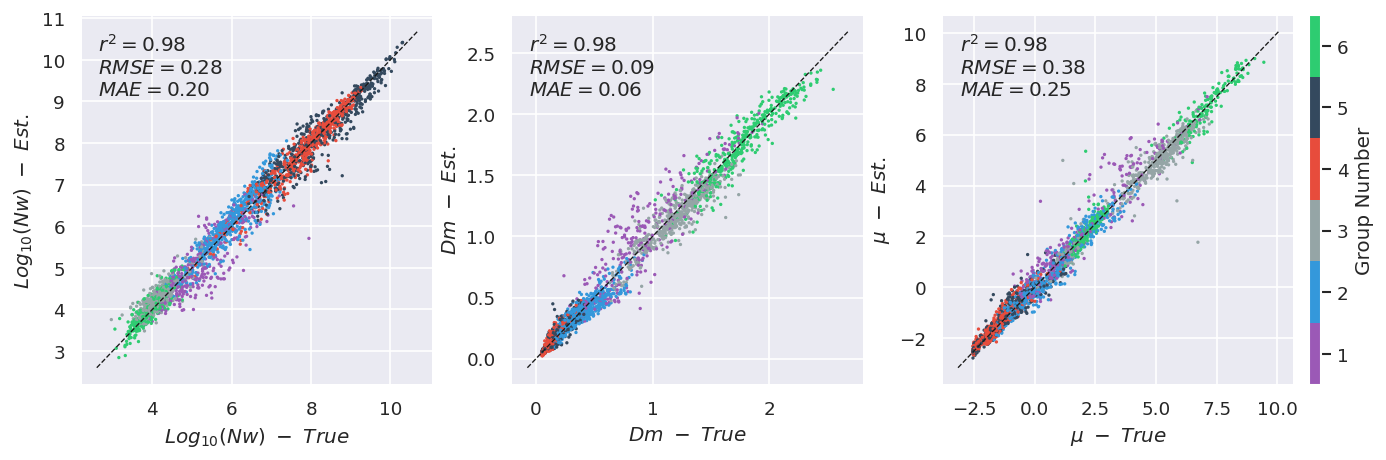

In [93]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

In [94]:
del scaler_x, scaler_y

# NN using DFR, Z_ku, Temp, Att_ku, and Att_ka

In [95]:
X, Y = df[['dbz_t_ku', 'dfr', 'temp', "Att_ka", 'Att_ka', 'log10_nw', 'dm', 'new_mu']], df[['dm_class', 'kmeans_6']]

In [96]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.33, random_state=42, stratify=df.kmeans_6)
X_train.shape

(5835, 8)

In [98]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0])
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0: 3942, 1: 3942})
Testing target statistics: Counter({0: 1961, 1: 914})


In [99]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [100]:
EPOCHS = 500
history = model.fit(X_res[:, :5], X_res[:, 5:],
                    validation_data=(X_test[:, :5], X_test[:, 5:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
...................................................................

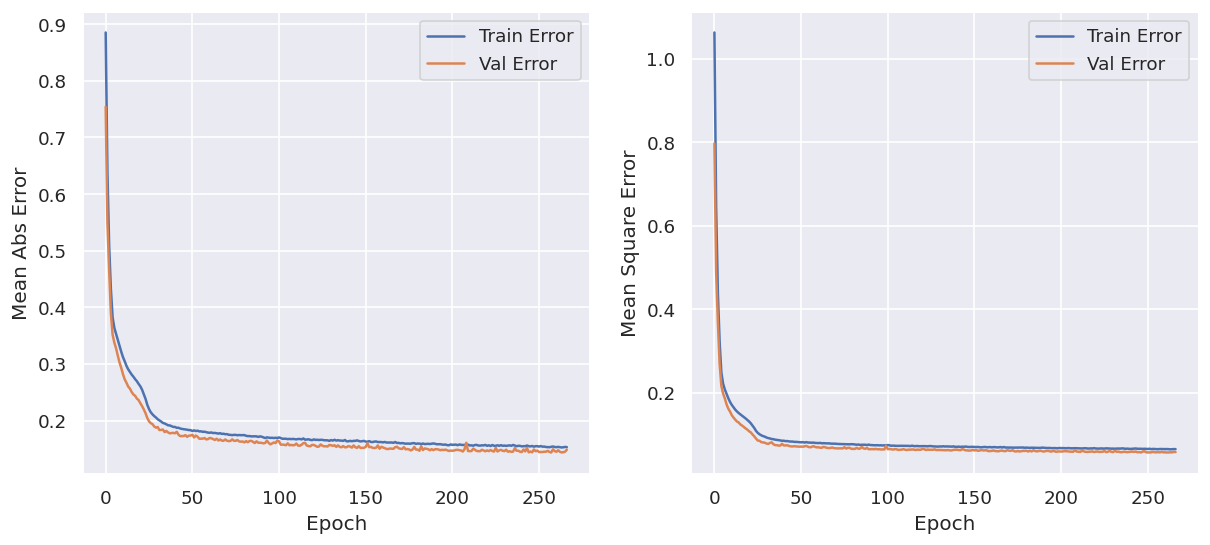

In [101]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [102]:
yhat = model.predict(X_test[:, :5])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 5:])

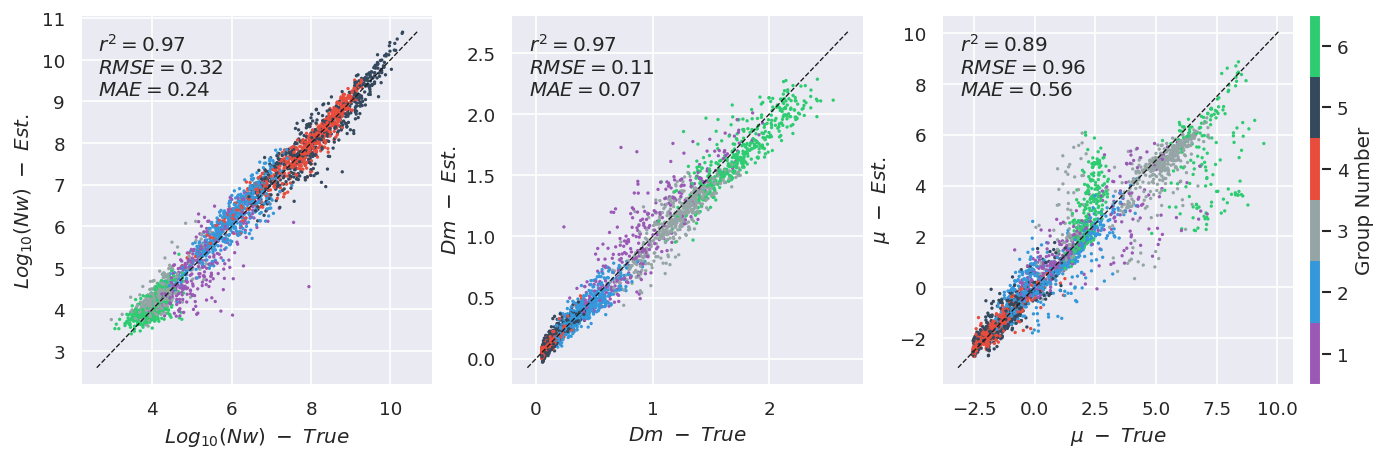

In [103]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

# NN using DFR, Z_ku, Temp, altitude, Att_ku, and Att_ka

In [234]:
X = df[['dbz_t_ku', 'dfr', 'temp', "Att_ka", 'Att_ka', 'altitude', 'log10_nw', 'dm', 'new_mu']]
Y = df[['dm_class', 'kmeans_6', 'r', 'r_dm_gm_mu_3', 'r_gpm_operational', 'r_true_nw_mu_dm', 'time']]

In [235]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.33, random_state=42, stratify=df.kmeans_6)
X_train.shape

(5835, 9)

In [211]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0])
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0.0: 3942, 1.0: 3942})
Testing target statistics: Counter({0.0: 1961, 1.0: 914})


In [161]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [162]:
EPOCHS = 500
history = model.fit(X_res[:, :6], X_res[:, 6:],
                    validation_data=(X_test[:, :6], X_test[:, 6:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [ ]:
model_path = f"{path_data}/cloud_probes"
model.save(f"{model_path}/model_dfr_zku_temp_alt_aku_aka.h5")

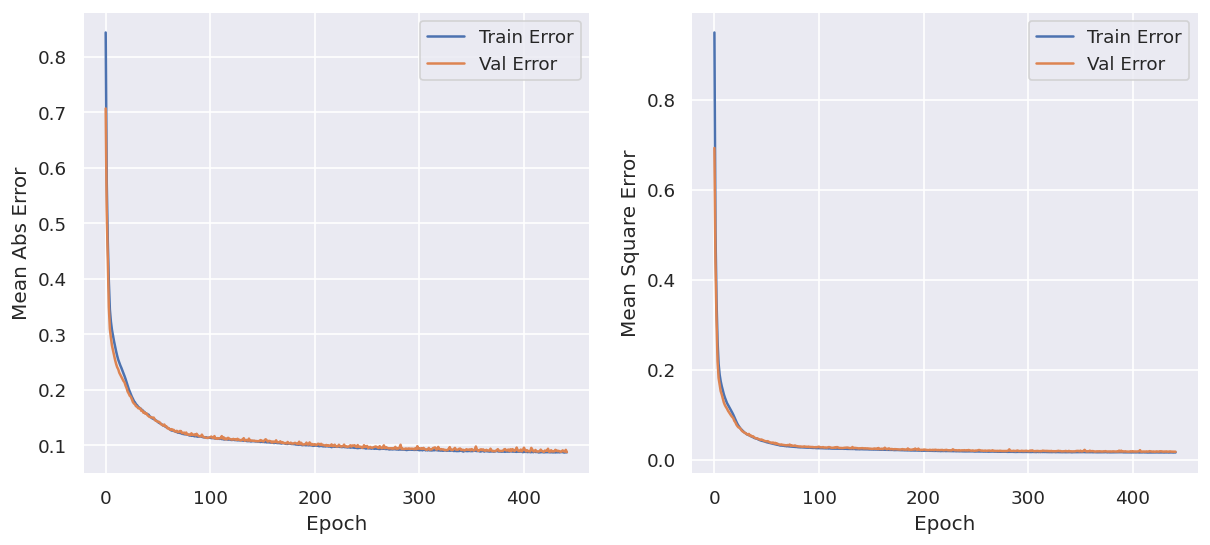

In [163]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [237]:
yhat = model.predict(X_test[:, :6])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 6:])

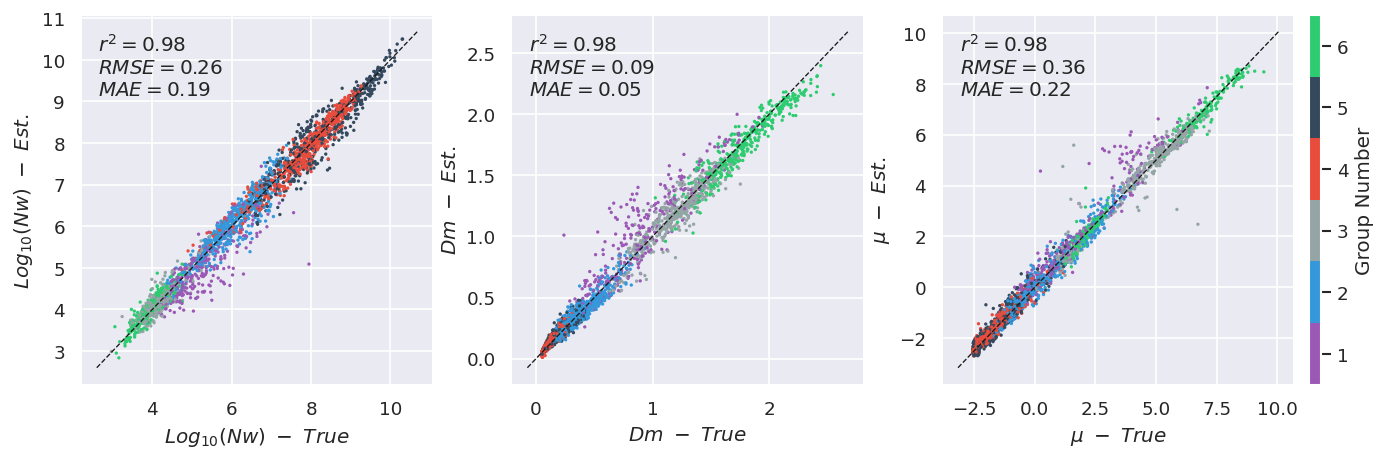

In [238]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, 1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, 1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, 1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

## Rainfall comparison

In [260]:
def metrics_pd(x, xpred):
    xpred = xpred.astype(float)
    x = x.astype(float)
    x = x[~np.isnan(xpred)]
    xpred = xpred[~np.isnan(xpred)]
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

def rain_retrieval(nw, mu, dm, d, d_d, vel_m='lerm'):
    lerm_vel: Callable[[float], float] = lambda diam: 9.25 * (1 - np.exp(-0.068 * diam ** 2 - 0.488 * diam))  # d in mm
    ulbr_vel: Callable[[float], float] = lambda diam: 3.78 * diam ** 0.67  # with d in mm
    if vel_m == 'lemr':
        vel = lerm_vel(d)
    else:
        vel = ulbr_vel(d)
    f_mu = (6 * (mu + 4) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4))
    r = 6 * np.pi * 1e-4 * (nw * f_mu * (d / dm) ** mu * np.exp(-(4 + mu) * (d / dm)) * vel * d ** 3 * d_d)
    return r.sum('diameter')

Text(0.5, 1.0, '$GPM \\ Theoretical \\ (\\mu=3)$')

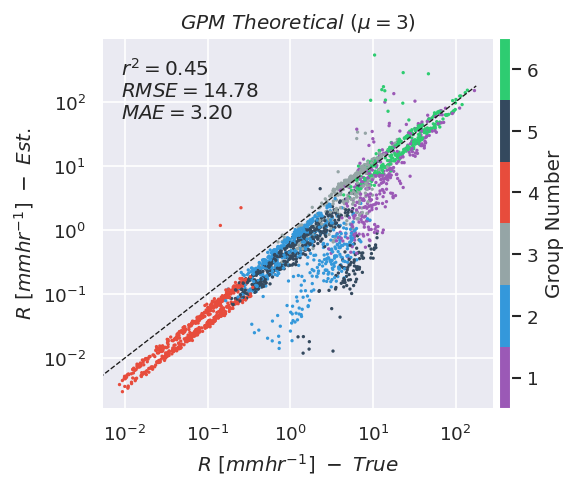

In [263]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4))
sc1 = ax.scatter(y_test[:, 2], y_test[:, 3], s=1, c=y_test[:, 1], cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], y_test[:, 3])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax.set_title(r"$GPM \ Theoretical \ (\mu=3)$")

Text(0.5, 1.0, '$GPM \\ Operational$')

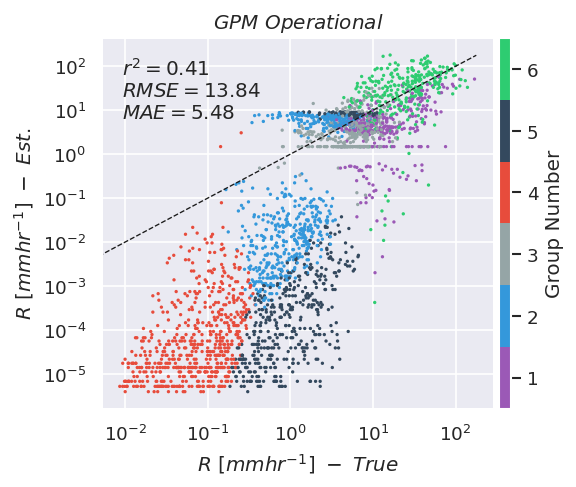

In [264]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4))
sc1 = ax.scatter(y_test[:, 2], y_test[:, 4], s=1, c=y_test[:, 1], cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], y_test[:, 4])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax.set_title(r"$GPM \ Operational$")

Text(0.5, 1.0, '$Gamma \\ shaped \\ PSD$')

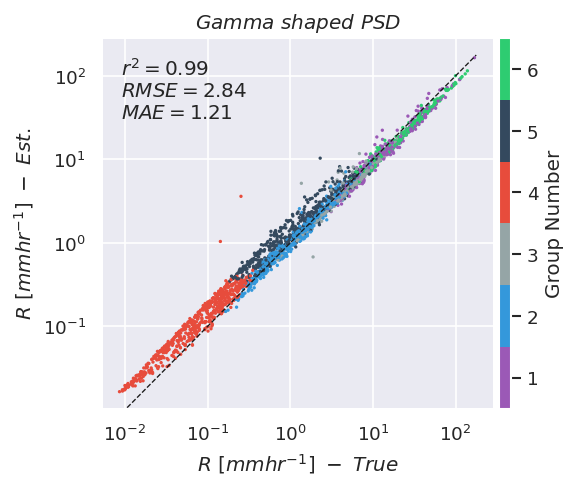

In [265]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4))
sc1 = ax.scatter(y_test[:, 2], y_test[:, 5], s=1, c=y_test[:, 1], cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], y_test[:, 5])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax.set_title(r"$Gamma \ shaped \ PSD$")

In [293]:
nw = yhat[:, 0]
dm = yhat[:, 1]
mu = yhat[:, 2]

In [294]:
ds_sub = xr.Dataset(
    data_vars=dict(
        nw = (["time"], 10 ** nw),
        dm = (["time"], dm),
        mu = (["time"], mu),
    ), 
    coords=dict(
        time=(["time"], y_test[:, -1]),
        diameter=(['diameter'], ds_lear.diameter.values)
    ),
)

In [303]:
d_d = ds_lear.d_d.isel(time=0).values
d_d = np.tile(d_d, (ds_sub.nw.shape[0], 1))
d_d = xr.DataArray(data=d_d,
                   dims=['time', "diameter"])
ds_sub['d_d'] = d_d

In [304]:
ds_sub['nn_gamma_pds'] = norm_gamma(ds_lear.diameter/100, nw=ds_sub.nw, mu=ds_sub.mu, dm=ds_sub.dm)

In [309]:
nn_rain = rain_retrieval(nw=ds_sub.nw, mu=ds_sub.mu, dm=ds_sub.dm, d=ds_sub.diameter/1e3, d_d=ds_sub.d_d/1e3, vel_m='das')

Text(0.5, 1.0, '$NN \\ retrieval$')

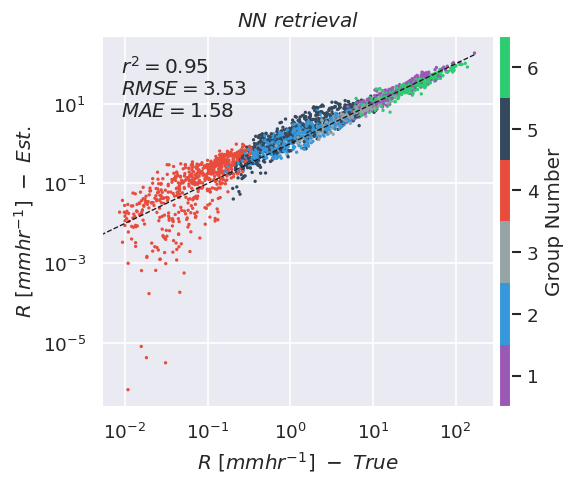

In [310]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4))
sc1 = ax.scatter(y_test[:, 2], nn_rain.values, s=1, c=y_test[:, 1], cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax.set_title(r"$NN \ retrieval$")